# Model Training

In [107]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import visualkeras

from tqdm import tqdm
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam

### Read Processed Data

In [2]:
listings_df = pd.read_csv('../data/processed/processed-listings.csv').dropna()
print('Number of listings: ' + str(len(listings_df)))

Number of listings: 94639


In [3]:
listings_df.head()

,Subtype,Style,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Date,Listing Year,Year of Construction,Age,Location,Price
0,2 Storey,2 storey,1191,4076,3,1,2,2020-12-01,2020,2004,16,Beauport,332500
1,Bungalow,Open area,1261,9500,2,1,1,2021-12-01,2021,1957,64,Portneuf,265000
2,Townhouse,Unknown,1645,1360,3,1,3,2021-11-01,2021,2006,15,Mercier-Hochelaga-Maisonneuve,612000
3,Semi-detached,2 storey,2400,4471,4,2,2,2021-12-01,2021,1989,32,Gatineau,360000
4,2 Storey,Unknown,1800,16090,5,2,2,2021-09-01,2021,1990,31,Lac-Saint-Jean-Est,284000


### Choosing columnns

In [4]:
ordinal_cols = []
one_hot_cols = ['Subtype', 'Location']
numerical_cols = ['Living Area', 'Lot Dimensions', 'Bedrooms', 'Bathrooms', 'Levels', 'Listing Year', 'Age']
target_col = ['Price']

In [5]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,Subtype,Location,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Age,Price
0,2 Storey,Beauport,1191,4076,3,1,2,2020,16,332500
1,Bungalow,Portneuf,1261,9500,2,1,1,2021,64,265000
2,Townhouse,Mercier-Hochelaga-Maisonneuve,1645,1360,3,1,3,2021,15,612000
3,Semi-detached,Gatineau,2400,4471,4,2,2,2021,32,360000
4,2 Storey,Lac-Saint-Jean-Est,1800,16090,5,2,2,2021,31,284000


### One Hot Encoding

In [6]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in tqdm(listings_df[col].unique()):   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


In [7]:
listings_df.head()

,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Age,Price,2 Storey_Subtype,Bungalow_Subtype,...,Kirkland_Location,"Senneville, Baie-D'Urfé & Saint-Anne-de-Bellevue_Location",Le Sud-Ouest_Location,Verdun_Location,Beaconsfield_Location,Saint-Léonard_Location,Ville de Mont-Royal_Location,Outremont_Location,Westmount_Location,Ville-Marie_Location
0,1191,4076,3,1,2,2020,16,332500,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1261,9500,2,1,1,2021,64,265000,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1645,1360,3,1,3,2021,15,612000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2400,4471,4,2,2,2021,32,360000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1800,16090,5,2,2,2021,31,284000,1,0,...,0,0,0,0,0,0,0,0,0,0


### Ordinal Encoding

In [8]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    listings_df[col] = ordinal_encoders[col].transform(listings_df[[col]])

listings_df.head()

,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Age,Price,2 Storey_Subtype,Bungalow_Subtype,...,Kirkland_Location,"Senneville, Baie-D'Urfé & Saint-Anne-de-Bellevue_Location",Le Sud-Ouest_Location,Verdun_Location,Beaconsfield_Location,Saint-Léonard_Location,Ville de Mont-Royal_Location,Outremont_Location,Westmount_Location,Ville-Marie_Location
0,1191,4076,3,1,2,2020,16,332500,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1261,9500,2,1,1,2021,64,265000,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1645,1360,3,1,3,2021,15,612000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2400,4471,4,2,2,2021,32,360000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1800,16090,5,2,2,2021,31,284000,1,0,...,0,0,0,0,0,0,0,0,0,0


### Split Data (Test/Train)

In [88]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Scale Data
Using Min Max Scaler

In [89]:
scaled_cols = numerical_cols + ordinal_cols

scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [90]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Age,2 Storey_Subtype,Bungalow_Subtype,Townhouse_Subtype,...,Kirkland_Location,"Senneville, Baie-D'Urfé & Saint-Anne-de-Bellevue_Location",Le Sud-Ouest_Location,Verdun_Location,Beaconsfield_Location,Saint-Léonard_Location,Ville de Mont-Royal_Location,Outremont_Location,Westmount_Location,Ville-Marie_Location
31038,0.116444,0.029899,0.50,0.333333,0.5,0.80,0.130178,0,0,1,...,0,0,0,0,0,0,0,0,0,0
46861,0.355556,0.177596,0.75,0.333333,0.5,0.65,0.213018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33840,0.400000,0.245919,1.00,0.666667,0.5,0.70,0.147929,1,0,0,...,0,0,0,0,0,0,0,0,0,0
60778,0.137333,0.163232,0.75,0.333333,0.5,0.50,0.130178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56747,0.308000,0.121212,1.00,0.666667,0.5,0.55,0.029586,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Neural Network Training

In [91]:
model = Sequential()
model.add(Dense(units=500 input_dim=X_train.shape[-1], activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1, activation="linear"))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 500)               64000     
                                                                 
 dense_25 (Dense)            (None, 100)               50100     
                                                                 
 dense_26 (Dense)            (None, 50)                5050      
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 119,201
Trainable params: 119,201
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
model.compile(optimizer=Adam(), loss="mean_squared_error")
history = model.fit(X_train, y_train, batch_size=80000, epochs=500, validation_data=(X_test, y_test))

Epoch 1/500
1/1 [==============================] - 1s 700ms/step - loss: 0.0639 - val_loss: 0.0163
Epoch 2/500
1/1 [==============================] - 0s 269ms/step - loss: 0.0168 - val_loss: 0.0193
Epoch 3/500
1/1 [==============================] - 0s 267ms/step - loss: 0.0185 - val_loss: 0.0277
Epoch 4/500
1/1 [==============================] - 0s 267ms/step - loss: 0.0265 - val_loss: 0.0228
Epoch 5/500
1/1 [==============================] - 0s 270ms/step - loss: 0.0218 - val_loss: 0.0152
Epoch 6/500
1/1 [==============================] - 0s 275ms/step - loss: 0.0146 - val_loss: 0.0113
Epoch 7/500
1/1 [==============================] - 0s 265ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 8/500
1/1 [==============================] - 0s 264ms/step - loss: 0.0113 - val_loss: 0.0126
Epoch 9/500
1/1 [==============================] - 0s 264ms/step - loss: 0.0129 - val_loss: 0.0134
Epoch 10/500
1/1 [==============================] - 0s 265ms/step - loss: 0.0138 - val_loss: 0.0130
Epoch 11/

In [113]:
def plot_loss(history):
  plt.figure(figsize=(14, 8))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history['loss'], 'dodgerblue', label='training loss')
  plt.plot(history.history['val_loss'], 'orangered', label='validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MSE]')
  plt.legend()
  plt.grid(True)
  plt.savefig('./figures/training/training.png', transparent=True, bbox_inches='tight')

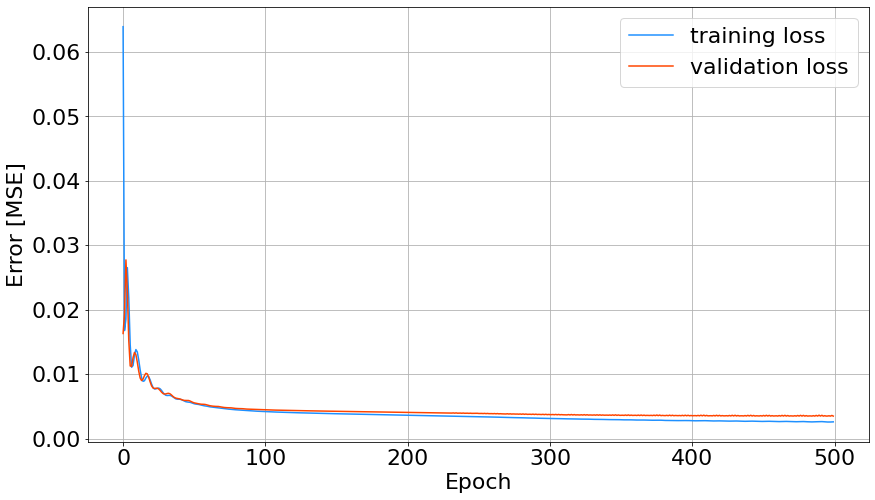

In [114]:
plot_loss(history)

In [95]:
predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [96]:
test_df = X_test.copy()

for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [97]:
d = {}
d['real price'] = list(real_prices)
d['predicted price'] = list(predicted_prices)

test_df['real price'] = d['real price']
test_df['predicted price'] = d['predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['predicted price'] = test_df['predicted price'].astype(int)

In [98]:
test_df.head(12)

,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Age,2 Storey_Subtype,Bungalow_Subtype,Townhouse_Subtype,...,Le Sud-Ouest_Location,Verdun_Location,Beaconsfield_Location,Saint-Léonard_Location,Ville de Mont-Royal_Location,Outremont_Location,Westmount_Location,Ville-Marie_Location,real price,predicted price
72597,1018.0,4400.0,3.0,2.0,1.0,2005.0,78.0,0,1,0,...,0,0,0,0,0,0,0,0,190000,182475
47050,1119.0,6649.0,3.0,2.0,1.0,2015.0,52.0,0,1,0,...,0,0,0,0,0,0,0,0,305000,290251
5832,760.0,3240.0,3.0,1.0,2.0,2021.0,36.0,0,0,0,...,0,0,0,0,0,0,0,0,250000,224970
20111,738.0,5400.0,2.0,1.0,1.0,2019.0,50.0,0,1,0,...,0,0,0,0,0,0,0,0,225000,200427
80641,1135.0,9291.0,2.0,1.0,1.0,2019.0,4.0,0,0,0,...,0,0,0,0,0,0,0,0,265000,309519
60626,864.0,5261.0,3.0,1.0,1.0,2011.0,21.0,0,1,0,...,0,0,0,0,0,0,0,0,195000,195480
28966,1980.0,11136.0,4.0,2.0,1.0,2017.0,34.0,0,0,0,...,0,0,0,0,0,0,0,0,359000,300177
63544,2800.0,13570.0,5.0,2.0,1.0,2010.0,50.0,0,1,0,...,0,0,0,0,0,0,0,0,425000,438934
4014,2432.0,9291.0,5.0,2.0,2.0,2021.0,2.0,1,0,0,...,0,0,0,0,0,0,0,0,610000,463487
20327,1127.0,6380.0,4.0,2.0,1.0,2019.0,27.0,0,0,0,...,0,0,0,0,0,0,0,0,252999,344943


In [99]:
errors = abs(predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

In [100]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 38913$
Error std ($): 42502$
Error Mean (%): 14.87%
Error std (%): 18.46%


### Saving Model

In [102]:
filepath = '../model'

save_model = False
if save_model:
    model.save(filepath)

INFO:tensorflow:Assets written to: ../model\assets


### Saving Scalers

In [109]:
for key in scalers.keys():
    joblib.dump(scalers[key], './scalers/' + key + '_scaler.pkl') 

In [112]:
joblib.dump(target_scaler, './scalers/Price_scaler.pkl') 

['./scalers/Price_scaler.pkl']

### Unencode test_df

In [ ]:
def unencode_column(df: pd.DataFrame, column: str):
    pass

In [ ]:
def unencode(df):
    for column in one_hot_cols:
        pass